In [ ]:
# Install required packages
!pip install deep_translator -q
!pip install --upgrade diffusers transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
from diffusers import StableDiffusionPipeline
from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt
import os
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Configuration class
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2-1"
    image_gen_size = (900, 900)
    image_gen_guidance_scale = 9

In [ ]:
def initialize_model(model_id, auth_token=None):
    """Initialize the Stable Diffusion model.

    Args:
        model_id (str): The model ID from Hugging Face.
        auth_token (str, optional): Hugging Face authentication token.

    Returns:
        StableDiffusionPipeline: The initialized model on the appropriate device.
    """
    try:
        if torch.cuda.is_available():
            print("GPU detected, using float16 precision.")
            model = StableDiffusionPipeline.from_pretrained(
                model_id, torch_dtype=torch.float16, use_auth_token=auth_token
            )
        else:
            print("No GPU detected, using float32 precision on CPU (slower).")
            model = StableDiffusionPipeline.from_pretrained(
                model_id, torch_dtype=torch.float32, use_auth_token=auth_token
            )
        return model.to(CFG.device)
    except Exception as e:
        print(f"Model initialization failed: {e}")
        return None

In [ ]:
def get_translation(text, dest_lang):
    """Translate text to the specified destination language using Google Translate.

    Args:
        text (str): The text to translate.
        dest_lang (str): The target language code (e.g., 'en' for English).

    Returns:
        str: The translated text, or original text if translation fails.
    """
    try:
        return GoogleTranslator(source='auto', target=dest_lang).translate(text)
    except Exception as e:
        print(f"Translation failed: {e}")
        return text

In [ ]:
def generate_image(prompt, model, steps=CFG.image_gen_steps, size=CFG.image_gen_size, guidance_scale=CFG.image_gen_guidance_scale):
    """Generate an image from a text prompt using Stable Diffusion and enable download in Colab."""
    try:
        with torch.no_grad():
            image = model(
                prompt, num_inference_steps=steps,
                generator=CFG.generator,
                guidance_scale=guidance_scale
            ).images[0]
        image = image.resize(size)

        # Save image to a file
        save_path = "/content/generated_image.png"
        image.save(save_path)
        print(f"Image saved to {save_path}")

        # Display download button
        download_button = widgets.Button(description="Download Image")
        output = widgets.Output()

        def on_button_click(b):
            with output:
                files.download(save_path)

        download_button.on_click(on_button_click)
        display(download_button, output)

        return image
    except Exception as e:
        print(f"Image generation failed: {e}")
        return None

Running on device: cuda
GPU detected, using float16 precision.


Keyword arguments {'use_auth_token': 'your_hugging_face_auth_token'} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Translated prompt: person on a table with dog


  0%|          | 0/35 [00:00<?, ?it/s]

Image saved to /content/generated_image.png


Button(description='Download Image', style=ButtonStyle())

Output()

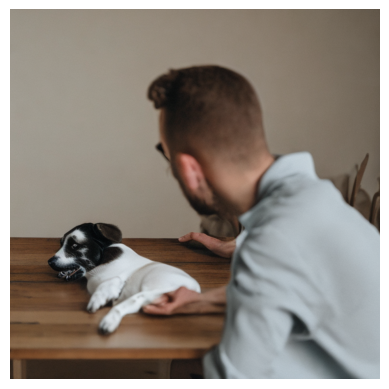

In [ ]:
# Main execution
if __name__ == "__main__":
    # Replace with your Hugging Face token
    auth_token = 'your_hugging_face_auth_token'

    # Verify device
    print(f"Running on device: {CFG.device}")

    # Initialize model
    model = initialize_model(CFG.image_gen_model_id, auth_token)

    if model:
        # Translate the Telugu prompt to English
        translation = get_translation("person on a table with dog", "en")
        print(f"Translated prompt: {translation}")

        # Generate and display the image
        image = generate_image(translation, model)
        if image:
            plt.imshow(image)
            plt.axis('off')
            plt.show()